# Method 8 - Best Ideas High Liquidity

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Use Raw Weight

valid_data['adj_target'] = valid_data['target']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Get Liquidity

distinct_ideas = best_ideas[['datadate', 'fsym_id']].drop_duplicates()
distinct_ideas['in'] = 1

bid_asks = crsp.get_crsp_fsym_bid_ask(list(set(distinct_ideas['fsym_id'].dropna())),
                                      distinct_ideas['datadate'].min(), pd.datetime(2018, 12, 31))
bid_asks['rel_bid_ask'] = (bid_asks['ask'] - bid_asks['bid']) / ((bid_asks['bid'] + bid_asks['ask']) / 2)
bid_asks['datadate'] = bid_asks['datadate'] + pd.offsets.QuarterEnd(0)
qe_bid_asks = bid_asks.groupby(['datadate', 'fsym_id'])['rel_bid_ask'].mean().reset_index()
qe_bid_asks = qe_bid_asks.merge(distinct_ideas)

qe_bid_asks['median_bid_ask'] = qe_bid_asks.groupby('datadate')['rel_bid_ask'].transform('median')
qe_bid_asks = qe_bid_asks[qe_bid_asks['rel_bid_ask'] < qe_bid_asks['median_bid_ask']]

best_ideas = best_ideas.merge(qe_bid_asks)

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

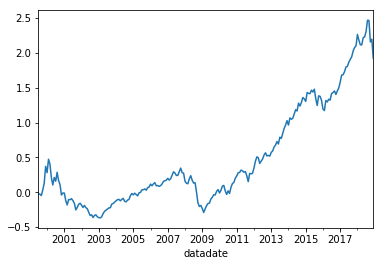

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.371089
2000-12-31   -0.279204
2001-12-31   -0.149398
2002-12-31   -0.231552
2003-12-31    0.327922
2004-12-31    0.143711
2005-12-31    0.095080
2006-12-31    0.092175
2007-12-31    0.085225
2008-12-31   -0.364218
2009-12-31    0.281555
2010-12-31    0.157241
2011-12-31    0.060258
2012-12-31    0.192947
2013-12-31    0.334898
2014-12-31    0.154239
2015-12-31   -0.008618
2016-12-31    0.076179
2017-12-31    0.242626
2018-12-31   -0.057766
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     425.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.09e-104
Time:                        07:29:48   Log-Likelihood:                 631.41
No. Observations:                 234   AIC:                            -1253.
Df Residuals:                     229   BIC:                            -1236.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.001      1.476      0.141      -0.001       0.004
mktrf          0.9155      0.031     29.812      0.000       0.855       0.976
me             0.2471      0.036      6.916      0.000       0.177       0.317
ia            -0.5087      0.054     -9.369      0.000      -0.616      -0.402
roe            0.1257      0.046      2.705      0.007       0.034       0.217
==============================================================================
Omnibus:                       85.689   Durbin-Watson:                   2.032
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1349.190
Skew:                           0.951   Prob(JB):                    1.06e-293
Kurtosis:                      14.609   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     232.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.02e-79
Time:                        07:29:48   Log-Likelihood:                 631.41
No. Observations:                 234   AIC:                            -1253.
Df Residuals:                     229   BIC:                            -1236.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.001      1.433      0.152      -0.001       0.004
mktrf          0.9155      0.039     23.356      0.000       0.839       0.992
me             0.2471      0.095      2.590      0.010       0.060       0.434
ia            -0.5087      0.129     -3.950      0.000      -0.761      -0.256
roe            0.1257      0.064      1.964      0.050       0.000       0.251
==============================================================================
Omnibus:                       85.689   Durbin-Watson:                   2.032
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1349.190
Skew:                           0.951   Prob(JB):                    1.06e-293
Kurtosis:                      14.609   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     321.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.24e-92
Time:                        07:29:48   Log-Likelihood:                 631.41
No. Observations:                 234   AIC:                            -1253.
Df Residuals:                     229   BIC:                            -1236.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.001      1.504      0.133      -0.001       0.004
mktrf          0.9155      0.031     29.576      0.000       0.855       0.976
me             0.2471      0.103      2.397      0.017       0.045       0.449
ia            -0.5087      0.116     -4.386      0.000      -0.736      -0.281
roe            0.1257      0.052      2.429      0.015       0.024       0.227
==============================================================================
Omnibus:                       85.689   Durbin-Watson:                   2.032
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1349.190
Skew:                           0.951   Prob(JB):                    1.06e-293
Kurtosis:                      14.609   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     376.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          5.66e-108
Time:                        07:29:48   Log-Likelihood:                 642.35
No. Observations:                 234   AIC:                            -1273.
Df Residuals:                     228   BIC:                            -1252.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      2.217      0.028       0.000       0.005
mktrf          0.8918      0.029     30.305      0.000       0.834       0.950
smb            0.2094      0.039      5.392      0.000       0.133       0.286
hml           -0.2802      0.046     -6.119      0.000      -0.370      -0.190
rmw           -0.0335      0.052     -0.648      0.518      -0.136       0.068
cma           -0.1437      0.066     -2.184      0.030      -0.273      -0.014
==============================================================================
Omnibus:                       87.824   Durbin-Watson:                   2.107
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1145.309
Skew:                           1.056   Prob(JB):                    1.99e-249
Kurtosis:                      13.630   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     546.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.06e-124
Time:                        07:29:48   Log-Likelihood:                 642.35
No. Observations:                 234   AIC:                            -1273.
Df Residuals:                     228   BIC:                            -1252.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      2.384      0.017       0.000       0.004
mktrf          0.8918      0.034     26.464      0.000       0.826       0.958
smb            0.2094      0.075      2.791      0.005       0.062       0.356
hml           -0.2802      0.070     -4.019      0.000      -0.417      -0.144
rmw           -0.0335      0.083     -0.403      0.687      -0.197       0.130
cma           -0.1437      0.147     -0.979      0.328      -0.431       0.144
==============================================================================
Omnibus:                       87.824   Durbin-Watson:                   2.107
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1145.309
Skew:                           1.056   Prob(JB):                    1.99e-249
Kurtosis:                      13.630   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     694.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          9.48e-136
Time:                        07:29:48   Log-Likelihood:                 642.35
No. Observations:                 234   AIC:                            -1273.
Df Residuals:                     228   BIC:                            -1252.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      2.472      0.013       0.000       0.004
mktrf          0.8918      0.033     26.947      0.000       0.827       0.957
smb            0.2094      0.077      2.735      0.006       0.059       0.359
hml           -0.2802      0.074     -3.762      0.000      -0.426      -0.134
rmw           -0.0335      0.080     -0.421      0.674      -0.190       0.123
cma           -0.1437      0.153     -0.941      0.346      -0.443       0.155
==============================================================================
Omnibus:                       87.824   Durbin-Watson:                   2.107
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1145.309
Skew:                           1.056   Prob(JB):                    1.99e-249
Kurtosis:                      13.630   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     675.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.78e-125
Time:                        07:29:49   Log-Likelihood:                 680.36
No. Observations:                 234   AIC:                            -1351.
Df Residuals:                     229   BIC:                            -1333.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      0.879      0.380      -0.001       0.003
mktrf          1.0089      0.023     43.985      0.000       0.964       1.054
smb            0.1462      0.029      5.107      0.000       0.090       0.203
hml           -0.2666      0.028     -9.375      0.000      -0.323      -0.211
umd            0.1788      0.019      9.579      0.000       0.142       0.216
==============================================================================
Omnibus:                       82.981   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              585.242
Skew:                           1.188   Prob(JB):                    8.25e-128
Kurtosis:                      10.374   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     280.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.67e-87
Time:                        07:29:49   Log-Likelihood:                 680.36
No. Observations:                 234   AIC:                            -1351.
Df Residuals:                     229   BIC:                            -1333.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      0.981      0.327      -0.001       0.002
mktrf          1.0089      0.036     27.813      0.000       0.938       1.080
smb            0.1462      0.051      2.881      0.004       0.047       0.246
hml           -0.2666      0.040     -6.604      0.000      -0.346      -0.188
umd            0.1788      0.042      4.244      0.000       0.096       0.261
==============================================================================
Omnibus:                       82.981   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              585.242
Skew:                           1.188   Prob(JB):                    8.25e-128
Kurtosis:                      10.374   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     275.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.53e-86
Time:                        07:29:49   Log-Likelihood:                 680.36
No. Observations:                 234   AIC:                            -1351.
Df Residuals:                     229   BIC:                            -1333.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      1.065      0.287      -0.001       0.002
mktrf          1.0089      0.041     24.876      0.000       0.929       1.088
smb            0.1462      0.044      3.351      0.001       0.061       0.232
hml           -0.2666      0.036     -7.454      0.000      -0.337      -0.197
umd            0.1788      0.046      3.863      0.000       0.088       0.269
==============================================================================
Omnibus:                       82.981   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              585.242
Skew:                           1.188   Prob(JB):                    8.25e-128
Kurtosis:                      10.374   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     198.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.18e-50
Time:                        07:29:49   Log-Likelihood:                 300.15
No. Observations:                 120   AIC:                            -590.3
Df Residuals:                     115   BIC:                            -576.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.002      0.248      0.804      -0.003       0.004
mktrf          0.9282      0.052     17.772      0.000       0.825       1.032
me             0.3466      0.052      6.719      0.000       0.244       0.449
ia            -0.5755      0.081     -7.124      0.000      -0.735      -0.415
roe            0.1752      0.072      2.450      0.016       0.034       0.317
==============================================================================
Omnibus:                       43.508   Durbin-Watson:                   2.043
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              317.078
Skew:                           0.937   Prob(JB):                     1.40e-69
Kurtosis:                      10.740   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     77.63
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           9.11e-32
Time:                        07:29:49   Log-Likelihood:                 300.15
No. Observations:                 120   AIC:                            -590.3
Df Residuals:                     115   BIC:                            -576.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.002      0.250      0.802      -0.003       0.004
mktrf          0.9282      0.076     12.170      0.000       0.779       1.078
me             0.3466      0.095      3.655      0.000       0.161       0.532
ia            -0.5755      0.151     -3.815      0.000      -0.871      -0.280
roe            0.1752      0.079      2.229      0.026       0.021       0.329
==============================================================================
Omnibus:                       43.508   Durbin-Watson:                   2.043
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              317.078
Skew:                           0.937   Prob(JB):                     1.40e-69
Kurtosis:                      10.740   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     91.22
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           9.44e-35
Time:                        07:29:49   Log-Likelihood:                 300.15
No. Observations:                 120   AIC:                            -590.3
Df Residuals:                     115   BIC:                            -576.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.002      0.281      0.779      -0.003       0.004
mktrf          0.9282      0.074     12.582      0.000       0.784       1.073
me             0.3466      0.103      3.359      0.001       0.144       0.549
ia            -0.5755      0.134     -4.288      0.000      -0.838      -0.312
roe            0.1752      0.062      2.816      0.005       0.053       0.297
==============================================================================
Omnibus:                       43.508   Durbin-Watson:                   2.043
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              317.078
Skew:                           0.937   Prob(JB):                     1.40e-69
Kurtosis:                      10.740   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     173.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.62e-51
Time:                        07:29:49   Log-Likelihood:                 305.11
No. Observations:                 120   AIC:                            -598.2
Df Residuals:                     114   BIC:                            -581.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.002      1.205      0.231      -0.001       0.006
mktrf          0.9022      0.053     16.997      0.000       0.797       1.007
smb            0.3181      0.060      5.292      0.000       0.199       0.437
hml           -0.3334      0.074     -4.526      0.000      -0.479      -0.187
rmw            0.0353      0.087      0.407      0.685      -0.137       0.207
cma           -0.1431      0.095     -1.504      0.135      -0.332       0.045
==============================================================================
Omnibus:                       36.666   Durbin-Watson:                   2.203
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              262.373
Skew:                           0.719   Prob(JB):                     1.06e-57
Kurtosis:                      10.100   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     191.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.06e-53
Time:                        07:29:49   Log-Likelihood:                 305.11
No. Observations:                 120   AIC:                            -598.2
Df Residuals:                     114   BIC:                            -581.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.002      1.352      0.176      -0.001       0.006
mktrf          0.9022      0.066     13.752      0.000       0.774       1.031
smb            0.3181      0.079      4.022      0.000       0.163       0.473
hml           -0.3334      0.083     -4.028      0.000      -0.496      -0.171
rmw            0.0353      0.080      0.442      0.658      -0.121       0.192
cma           -0.1431      0.199     -0.719      0.472      -0.533       0.247
==============================================================================
Omnibus:                       36.666   Durbin-Watson:                   2.203
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              262.373
Skew:                           0.719   Prob(JB):                     1.06e-57
Kurtosis:                      10.100   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     190.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.21e-53
Time:                        07:29:49   Log-Likelihood:                 305.11
No. Observations:                 120   AIC:                            -598.2
Df Residuals:                     114   BIC:                            -581.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.002      1.311      0.190      -0.001       0.006
mktrf          0.9022      0.071     12.681      0.000       0.763       1.042
smb            0.3181      0.071      4.471      0.000       0.179       0.458
hml           -0.3334      0.090     -3.696      0.000      -0.510      -0.157
rmw            0.0353      0.070      0.504      0.614      -0.102       0.173
cma           -0.1431      0.206     -0.695      0.487      -0.547       0.261
==============================================================================
Omnibus:                       36.666   Durbin-Watson:                   2.203
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              262.373
Skew:                           0.719   Prob(JB):                     1.06e-57
Kurtosis:                      10.100   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     399.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.03e-66
Time:                        07:29:49   Log-Likelihood:                 338.10
No. Observations:                 120   AIC:                            -666.2
Df Residuals:                     115   BIC:                            -652.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.001      1.131      0.260      -0.001       0.004
mktrf          1.0701      0.034     31.904      0.000       1.004       1.136
smb            0.1768      0.038      4.629      0.000       0.101       0.252
hml           -0.2755      0.038     -7.202      0.000      -0.351      -0.200
umd            0.2224      0.024      9.433      0.000       0.176       0.269
==============================================================================
Omnibus:                       27.566   Durbin-Watson:                   2.070
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              112.006
Skew:                           0.650   Prob(JB):                     4.77e-25
Kurtosis:                       7.551   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     156.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.40e-45
Time:                        07:29:49   Log-Likelihood:                 338.10
No. Observations:                 120   AIC:                            -666.2
Df Residuals:                     115   BIC:                            -652.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.001      1.471      0.141      -0.001       0.004
mktrf          1.0701      0.048     22.277      0.000       0.976       1.164
smb            0.1768      0.039      4.495      0.000       0.100       0.254
hml           -0.2755      0.037     -7.463      0.000      -0.348      -0.203
umd            0.2224      0.042      5.300      0.000       0.140       0.305
==============================================================================
Omnibus:                       27.566   Durbin-Watson:                   2.070
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              112.006
Skew:                           0.650   Prob(JB):                     4.77e-25
Kurtosis:                       7.551   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     153.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.80e-45
Time:                        07:29:49   Log-Likelihood:                 338.10
No. Observations:                 120   AIC:                            -666.2
Df Residuals:                     115   BIC:                            -652.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.001      1.652      0.099      -0.000       0.003
mktrf          1.0701      0.052     20.539      0.000       0.968       1.172
smb            0.1768      0.029      6.192      0.000       0.121       0.233
hml           -0.2755      0.029     -9.662      0.000      -0.331      -0.220
umd            0.2224      0.044      5.101      0.000       0.137       0.308
==============================================================================
Omnibus:                       27.566   Durbin-Watson:                   2.070
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              112.006
Skew:                           0.650   Prob(JB):                     4.77e-25
Kurtosis:                       7.551   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     477.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.29e-68
Time:                        07:29:49   Log-Likelihood:                 385.85
No. Observations:                 114   AIC:                            -761.7
Df Residuals:                     109   BIC:                            -748.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      2.199      0.030       0.000       0.003
mktrf          0.9595      0.025     38.917      0.000       0.911       1.008
me            -0.0389      0.038     -1.022      0.309      -0.114       0.037
ia            -0.2854      0.053     -5.405      0.000      -0.390      -0.181
roe            0.1091      0.046      2.352      0.020       0.017       0.201
==============================================================================
Omnibus:                        6.747   Durbin-Watson:                   1.815
Prob(Omnibus):                  0.034   Jarque-Bera (JB):                6.383
Skew:                           0.477   Prob(JB):                       0.0411
Kurtosis:                       3.659   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     844.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.08e-81
Time:                        07:29:49   Log-Likelihood:                 385.85
No. Observations:                 114   AIC:                            -761.7
Df Residuals:                     109   BIC:                            -748.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      1.800      0.072      -0.000       0.004
mktrf          0.9595      0.021     44.756      0.000       0.918       1.002
me            -0.0389      0.046     -0.847      0.397      -0.129       0.051
ia            -0.2854      0.052     -5.535      0.000      -0.386      -0.184
roe            0.1091      0.051      2.126      0.033       0.009       0.210
==============================================================================
Omnibus:                        6.747   Durbin-Watson:                   1.815
Prob(Omnibus):                  0.034   Jarque-Bera (JB):                6.383
Skew:                           0.477   Prob(JB):                       0.0411
Kurtosis:                       3.659   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     1273.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.78e-90
Time:                        07:29:49   Log-Likelihood:                 385.85
No. Observations:                 114   AIC:                            -761.7
Df Residuals:                     109   BIC:                            -748.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      1.779      0.075      -0.000       0.004
mktrf          0.9595      0.018     53.548      0.000       0.924       0.995
me            -0.0389      0.041     -0.942      0.346      -0.120       0.042
ia            -0.2854      0.055     -5.231      0.000      -0.392      -0.178
roe            0.1091      0.046      2.387      0.017       0.020       0.199
==============================================================================
Omnibus:                        6.747   Durbin-Watson:                   1.815
Prob(Omnibus):                  0.034   Jarque-Bera (JB):                6.383
Skew:                           0.477   Prob(JB):                       0.0411
Kurtosis:                       3.659   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     451.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.17e-70
Time:                        07:29:49   Log-Likelihood:                 395.42
No. Observations:                 114   AIC:                            -778.8
Df Residuals:                     108   BIC:                            -762.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      1.470      0.145      -0.000       0.003
mktrf          0.9508      0.022     43.776      0.000       0.908       0.994
smb           -0.0466      0.035     -1.321      0.189      -0.116       0.023
hml           -0.0839      0.045     -1.865      0.065      -0.173       0.005
rmw            0.0648      0.055      1.177      0.242      -0.044       0.174
cma           -0.2456      0.070     -3.514      0.001      -0.384      -0.107
==============================================================================
Omnibus:                        7.867   Durbin-Watson:                   1.699
Prob(Omnibus):                  0.020   Jarque-Bera (JB):                8.703
Skew:                           0.440   Prob(JB):                       0.0129
Kurtosis:                       4.028   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     931.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.52e-87
Time:                        07:29:49   Log-Likelihood:                 395.42
No. Observations:                 114   AIC:                            -778.8
Df Residuals:                     108   BIC:                            -762.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      1.444      0.149      -0.000       0.003
mktrf          0.9508      0.020     47.736      0.000       0.912       0.990
smb           -0.0466      0.040     -1.177      0.239      -0.124       0.031
hml           -0.0839      0.036     -2.319      0.020      -0.155      -0.013
rmw            0.0648      0.046      1.407      0.159      -0.025       0.155
cma           -0.2456      0.052     -4.684      0.000      -0.348      -0.143
==============================================================================
Omnibus:                        7.867   Durbin-Watson:                   1.699
Prob(Omnibus):                  0.020   Jarque-Bera (JB):                8.703
Skew:                           0.440   Prob(JB):                       0.0129
Kurtosis:                       4.028   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     1253.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.14e-94
Time:                        07:29:49   Log-Likelihood:                 395.42
No. Observations:                 114   AIC:                            -778.8
Df Residuals:                     108   BIC:                            -762.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      1.403      0.161      -0.000       0.003
mktrf          0.9508      0.019     49.796      0.000       0.913       0.988
smb           -0.0466      0.037     -1.245      0.213      -0.120       0.027
hml           -0.0839      0.035     -2.376      0.017      -0.153      -0.015
rmw            0.0648      0.048      1.363      0.173      -0.028       0.158
cma           -0.2456      0.044     -5.571      0.000      -0.332      -0.159
==============================================================================
Omnibus:                        7.867   Durbin-Watson:                   1.699
Prob(Omnibus):                  0.020   Jarque-Bera (JB):                8.703
Skew:                           0.440   Prob(JB):                       0.0129
Kurtosis:                       4.028   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     511.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.27e-69
Time:                        07:29:49   Log-Likelihood:                 389.54
No. Observations:                 114   AIC:                            -769.1
Df Residuals:                     109   BIC:                            -755.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      1.004      0.317      -0.001       0.002
mktrf          0.9568      0.023     42.298      0.000       0.912       1.002
smb           -0.0612      0.035     -1.736      0.085      -0.131       0.009
hml           -0.1868      0.036     -5.142      0.000      -0.259      -0.115
umd            0.0302      0.027      1.103      0.272      -0.024       0.085
==============================================================================
Omnibus:                        9.335   Durbin-Watson:                   1.684
Prob(Omnibus):                  0.009   Jarque-Bera (JB):               10.694
Skew:                           0.502   Prob(JB):                      0.00476
Kurtosis:                       4.116   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     769.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.01e-79
Time:                        07:29:49   Log-Likelihood:                 389.54
No. Observations:                 114   AIC:                            -769.1
Df Residuals:                     109   BIC:                            -755.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      0.946      0.344      -0.001       0.002
mktrf          0.9568      0.023     41.115      0.000       0.911       1.002
smb           -0.0612      0.043     -1.436      0.151      -0.145       0.022
hml           -0.1868      0.028     -6.737      0.000      -0.241      -0.132
umd            0.0302      0.025      1.223      0.221      -0.018       0.079
==============================================================================
Omnibus:                        9.335   Durbin-Watson:                   1.684
Prob(Omnibus):                  0.009   Jarque-Bera (JB):               10.694
Skew:                           0.502   Prob(JB):                      0.00476
Kurtosis:                       4.116   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     1172.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.45e-88
Time:                        07:29:49   Log-Likelihood:                 389.54
No. Observations:                 114   AIC:                            -769.1
Df Residuals:                     109   BIC:                            -755.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      1.028      0.304      -0.001       0.002
mktrf          0.9568      0.019     49.897      0.000       0.919       0.994
smb           -0.0612      0.042     -1.471      0.141      -0.143       0.020
hml           -0.1868      0.030     -6.184      0.000      -0.246      -0.128
umd            0.0302      0.022      1.384      0.166      -0.013       0.073
==============================================================================
Omnibus:                        9.335   Durbin-Watson:                   1.684
Prob(Omnibus):                  0.009   Jarque-Bera (JB):               10.694
Skew:                           0.502   Prob(JB):                      0.00476
Kurtosis:                       4.116   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""